## Import Library

In [ ]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from xgboost import XGBClassifier

from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

## Download Dataset

In [ ]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
TRAIN_PATH = os.path.join(path, "Training")
TEST_PATH = os.path.join(path, "Testing")

## Check Size Some Photo

In [ ]:
for i, f in enumerate(os.listdir(os.path.join(TRAIN_PATH, 'notumor'))):
  if i == 10:
    break
  img_path = os.path.join(TRAIN_PATH, 'notumor', f)
  print(cv2.imread(img_path).shape)

(225, 225, 3)
(630, 630, 3)
(236, 214, 3)
(192, 192, 3)
(630, 630, 3)
(225, 225, 3)
(848, 785, 3)
(512, 512, 3)
(248, 208, 3)
(417, 428, 3)


## Load Dataset

In [ ]:
def load_prep(dataset_path: str):
  label_class = os.listdir(dataset_path)
  class_list = []
  images = []

  kernel_filter = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

  for i, label in enumerate(label_class):
    label_path = os.path.join(dataset_path, label)
    for f in os.listdir(label_path):
      img_path = os.path.join(label_path, f)
      img = cv2.imread(img_path)
      # Resize
      img = cv2.resize(img, (224, 224))
      # Grayscale
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      # Histogram Equalization
      img = cv2.equalizeHist(img)
      # Noise Reduction
      img = cv2.medianBlur(img, 5)
      # Sharpening
      img = cv2.filter2D(img, -1, kernel_filter)
      # Normalization
      img = img / 255.0

      images.append(img)
      class_list.append(i)

  return np.asarray(images), np.asarray(class_list)

In [ ]:
train_images, train_labels = load_prep(TRAIN_PATH)
test_images, test_labels = load_prep(TEST_PATH)

## Feature Extraction

In [ ]:
def feature_extraction(images: np.ndarray, distances = [1], angles = [0]):
  glcm_features = []
  lbp_features = []

  for img in images:
    img_u8 = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

    # GLCM
    glcm = graycomatrix(img_u8,
                        distances=distances,
                        angles=angles,
                        levels=256,
                        symmetric=True,
                        normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_vector = [contrast, energy, homogeneity, correlation]
    glcm_features.append(glcm_vector)

    # LBP
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(img_u8, n_points, radius, method='uniform')
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, n_points + 3),
        range=(0, n_points + 2)
    )
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    lbp_features.append(hist)

  glcm_features = np.asarray(glcm_features)
  lbp_features = np.asarray(lbp_features)
  combined = np.hstack((glcm_features, lbp_features))

  return combined

In [ ]:
train_features = feature_extraction(train_images)
test_features = feature_extraction(test_images)

## Scaling

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

## Modeling

In [ ]:
model_svm = SVC(random_state=42)
model_random_forest = RandomForestClassifier(n_estimators=200, random_state=42)
model_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)

model_svm.fit(train_features, train_labels)
model_random_forest.fit(train_features, train_labels)
model_xgb.fit(train_features, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
svm_pred = model_svm.predict(test_features)
rf_pred = model_random_forest.predict(test_features)
xgb_pred = model_xgb.predict(test_features)

svm_acc = accuracy_score(test_labels, svm_pred)
rf_acc = accuracy_score(test_labels, rf_pred)
xgb_acc = accuracy_score(test_labels, xgb_pred)

svm_recall = recall_score(test_labels, svm_pred, average='macro')
rf_recall = recall_score(test_labels, rf_pred, average='macro')
xgb_recall = recall_score(test_labels, xgb_pred, average='macro')

svm_precision = precision_score(test_labels, svm_pred, average='macro')
rf_precision = precision_score(test_labels, rf_pred, average='macro')
xgb_precision = precision_score(test_labels, xgb_pred, average='macro')

svm_f1 = f1_score(test_labels, svm_pred, average='macro')
rf_f1 = f1_score(test_labels, rf_pred, average='macro')
xgb_f1 = f1_score(test_labels, xgb_pred, average='macro')

print(f'SVM Accuracy Score: {svm_acc}')
print(f'Random Forest Accuracy Score: {rf_acc}')
print(f'XGBoost Accuracy Score: {xgb_acc}')
print()
print(f'SVM Recall Score: {svm_recall}')
print(f'Random Forest Recall Score: {rf_recall}')
print(f'XGBoost Recall Score: {xgb_recall}')
print()
print(f'SVM Precision Score: {svm_precision}')
print(f'Random Forest Precision Score: {rf_precision}')
print(f'XGBoost Precision Score: {xgb_precision}')
print()
print(f'SVM F1 Score: {svm_f1}')
print(f'Random Forest F1 Score: {rf_f1}')
print(f'XGBoost F1 Score: {xgb_f1}')

SVM Accuracy Score: 0.7589626239511823
Random Forest Accuracy Score: 0.8825324180015256
XGBoost Accuracy Score: 0.8459191456903128

SVM Recall Score: 0.7442338416848221
Random Forest Recall Score: 0.8737509077705156
XGBoost Recall Score: 0.835

SVM Precision Score: 0.7420436302055711
Random Forest Precision Score: 0.8806669342427447
XGBoost Precision Score: 0.838792163786679

SVM F1 Score: 0.7370729377750233
Random Forest F1 Score: 0.8727820456263905
XGBoost F1 Score: 0.8348318269580759


In [ ]:
print('SVM Classification Report')
print(classification_report(test_labels, svm_pred))

SVM Classification Report
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       300
           1       0.81      0.94      0.87       405
           2       0.61      0.48      0.54       306
           3       0.75      0.62      0.68       300

    accuracy                           0.76      1311
   macro avg       0.74      0.74      0.74      1311
weighted avg       0.75      0.76      0.75      1311



In [ ]:
print('Random Forest Classification Report')
print(classification_report(test_labels, rf_pred))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       300
           1       0.96      0.98      0.97       405
           2       0.77      0.89      0.82       306
           3       0.89      0.69      0.78       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.89      0.88      0.88      1311



In [ ]:
print('XGBoost Classification Report')
print(classification_report(test_labels, xgb_pred))

XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       300
           1       0.90      0.98      0.94       405
           2       0.73      0.72      0.73       306
           3       0.84      0.70      0.76       300

    accuracy                           0.85      1311
   macro avg       0.84      0.83      0.83      1311
weighted avg       0.84      0.85      0.84      1311



## Hyperparameter Tuning

### Random Forest

In [ ]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    scoring='accuracy'
)

search.fit(train_features, train_labels)
print(search.best_params_)
print(search.best_score_)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
0.8653722575396114


In [ ]:
rf_tuned = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    max_depth=None
)

rf_tuned.fit(train_features, train_labels)
rf_acc_tuned = accuracy_score(test_labels, rf_tuned.predict(test_features))
rf_recall_tuned = recall_score(test_labels, rf_tuned.predict(test_features), average='macro')
rf_precision_tuned = precision_score(test_labels, rf_tuned.predict(test_features), average='macro')
rf_f1_tuned = f1_score(test_labels, rf_tuned.predict(test_features), average='macro')

print(f'Accuracy Random Forest Tuned: {rf_acc_tuned}')
print(f'Recall Random Forest Tuned: {rf_recall_tuned}')
print(f'Precision Random Forest Tuned: {rf_precision_tuned}')
print(f'F1 Random Forest Tuned: {rf_f1_tuned}')

Accuracy Random Forest Tuned: 0.8810068649885584
Recall Random Forest Tuned: 0.8719335511982571
Precision Random Forest Tuned: 0.8783373349590575
F1 Random Forest Tuned: 0.8715379795782858


### SVM

In [ ]:
svc = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    svc,
    param_grid,
    cv=cv,
    scoring='accuracy'
)

search.fit(train_features, train_labels)
print(search.best_params_)
print(search.best_score_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.8862047673112665


In [ ]:
svc_tuned = SVC(kernel='rbf', C=10, gamma=1)
svc_tuned.fit(train_features, train_labels)

svc_tuned_acc = accuracy_score(test_labels, svc_tuned.predict(test_features))
svc_tuned_recall = recall_score(test_labels, svc_tuned.predict(test_features), average='macro')
svc_tuned_precision = precision_score(test_labels, svc_tuned.predict(test_features), average='macro')
svc_tuned_f1 = f1_score(test_labels, svc_tuned.predict(test_features), average='macro')

print(f'Accuracy SVM Tuned: {svc_tuned_acc}')
print(f'Recall SVM Tuned: {svc_tuned_recall}')
print(f'Precision SVM Tuned: {svc_tuned_precision}')
print(f'F1 SVM Tuned: {svc_tuned_f1}')

Accuracy SVM Tuned: 0.9000762776506483
Recall SVM Tuned: 0.8917883079157588
Precision SVM Tuned: 0.8993129505170874
F1 SVM Tuned: 0.8917477403983837


### XGBoost

In [ ]:
xgb = XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    xgb,
    param_grid,
    cv=cv,
    scoring='accuracy'
)

search.fit(train_features, train_labels)
print(search.best_params_)
print(search.best_score_)

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
0.8706243593456247


In [ ]:
xgb_tuned = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.7,
    gamma=0,
    random_state=42,
    eval_metric='logloss'
)

xgb_tuned.fit(train_features, train_labels)

xgb_tuned_acc = accuracy_score(test_labels, xgb_tuned.predict(test_features))
xgb_tuned_recall = recall_score(test_labels, xgb_tuned.predict(test_features), average='macro')
xgb_tuned_precision = precision_score(test_labels, xgb_tuned.predict(test_features), average='macro')
xgb_tuned_f1 = f1_score(test_labels, xgb_tuned.predict(test_features), average='macro')

print(f'Accuracy XGBoost Tuned: {xgb_tuned_acc}')
print(f'Recall XGBoost Tuned: {xgb_tuned_recall}')
print(f'Precision XGBoost Tuned: {xgb_tuned_precision}')
print(f'F1 XGBoost Tuned: {xgb_tuned_f1}')

Accuracy XGBoost Tuned: 0.8947368421052632
Recall XGBoost Tuned: 0.886517792302106
Precision XGBoost Tuned: 0.8917489009111454
F1 XGBoost Tuned: 0.88626072708923


## Learning Curve

### SVM

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py", line 207, in fit
    y = self._validate_targets(y)
        

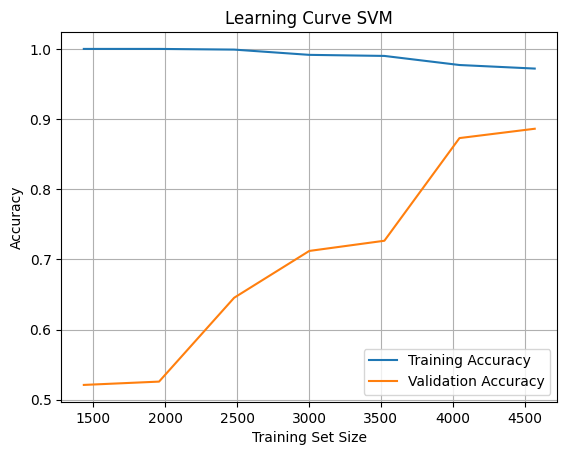

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, val_scores = learning_curve(
    svc_tuned,
    train_features,
    train_labels,
    cv=cv,
    scoring='accuracy',
    train_sizes=np.linspace(0.2, 1.0, 8),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve SVM')
plt.legend()
plt.grid()
plt.show()

### Random Forest

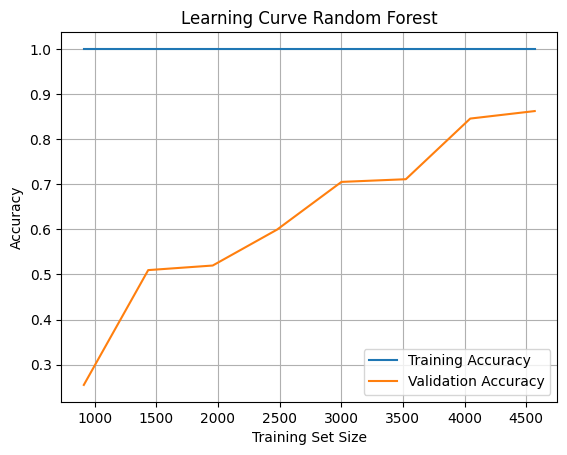

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, val_scores = learning_curve(
    rf_tuned,
    train_features,
    train_labels,
    cv=cv,
    scoring='accuracy',
    train_sizes=np.linspace(0.2, 1.0, 8),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve Random Forest')
plt.legend()
plt.grid()
plt.show()

### XGBoost

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1806, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.12/di

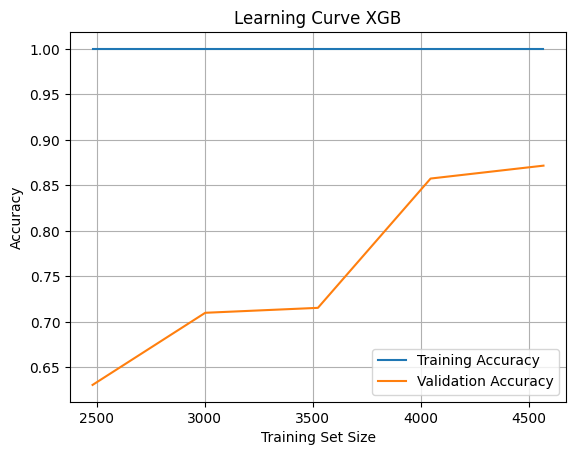

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_sizes, train_scores, val_scores = learning_curve(
    xgb_tuned,
    train_features,
    train_labels,
    cv=cv,
    scoring='accuracy',
    train_sizes=np.linspace(0.2, 1.0, 8),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, val_mean, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve XGB')
plt.legend()
plt.grid()
plt.show()